## This notebook explores a basic jerk analysis for the path model for jerk signatures. 
### It shows how to read in the datafiles from https://morpho.ipgp.fr/4DEarth/ and produce basic figures.

In [1]:
import sys
import os
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
sys.path.append( os.path.abspath('..') ) #This line needs to point to whereever the jerks module has been compiled.
from jerks import jerks

In [2]:
# Download the spherical harmonic time-series output from the path model
import os.path
if not os.path.exists('Gauss_Bsurf.mat'): 
    !wget http://morpho.ipgp.fr/4DEarth/Gauss_Bsurf.mat

In [3]:
# import the (Matlab formatted) dataset
import h5py
filepath = 'Gauss_Bsurf.mat'
arrays = {}
f = h5py.File(filepath,'r')
for k, v in f.items():
    arrays[k] = np.array(v)

In [4]:
coeffs = arrays['gnm'][:,:].T
time = arrays['timers'].flatten()
print( 'Shape of gmn array: ', arrays['gnm'].shape )
print ('Times (in years) of output', time )

Shape of gmn array:  (960, 50001)
Times (in years) of output [ 4200.   4200.2  4200.4 ... 14199.6 14199.8 14200. ]


In [5]:
# jerk times as defined in catalogue
jerk_times = [4600,5750,2920, 1915, 6490,7300,7620,7840,8880,9673,10590,12620,13411,13546]

#### Plot a picture of Br at the CMB at the time of jerk 9 (Python index 8, t=8880) to check that everything works

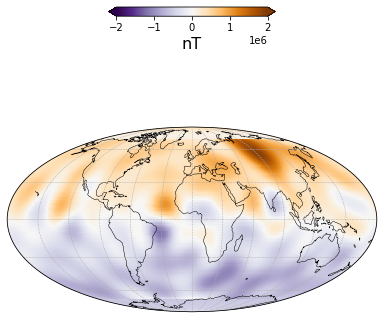

In [6]:
import chaosmagpy as cp
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec

index = np.argmin(abs(time-jerk_times[8]))

coeffs_single_epoch = arrays['gnm'][:,index]

radius = 3485.

theta = np.linspace(1., 179., 181)
phi = np.linspace(-180., 180, 361)
Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs_single_epoch, radius, theta, phi, grid=True,nmax=13)

limit = 2e6  # nT colorbar limit

# create figure
fig = plt.figure(figsize=(16, 10))

# make array of axes
axes = []
gs = fig.add_gridspec(3,3)
axes.append(plt.subplot(gs[1, :], projection=ccrs.Mollweide()))

for ax in axes:
    pc = ax.pcolormesh(phi, 90. - theta, Br, cmap='PuOr_r', vmin=-limit,
                       vmax=limit, transform=ccrs.PlateCarree())
    ax.gridlines(linewidth=0.5, linestyle='dashed',
                 ylocs=np.linspace(-90, 90, num=7),  # parallels
                 xlocs=np.linspace(-180, 180, num=13))  # meridians
    ax.coastlines(linewidth=0.5)

# inset axes into global map and move upwards
cax = inset_axes(axes[-1], width="45%", height="5%", loc='upper center',
                 borderpad=-12)

# use last artist for the colorbar
clb = plt.colorbar(pc, cax=cax, extend='both', orientation='horizontal')
clb.set_label('nT', fontsize=16)

plt.subplots_adjust(top=0.785, bottom=0.015, left=0.008,
                    right=0.992, hspace=0.0, wspace=0.0)

# Analysis of jerk 9

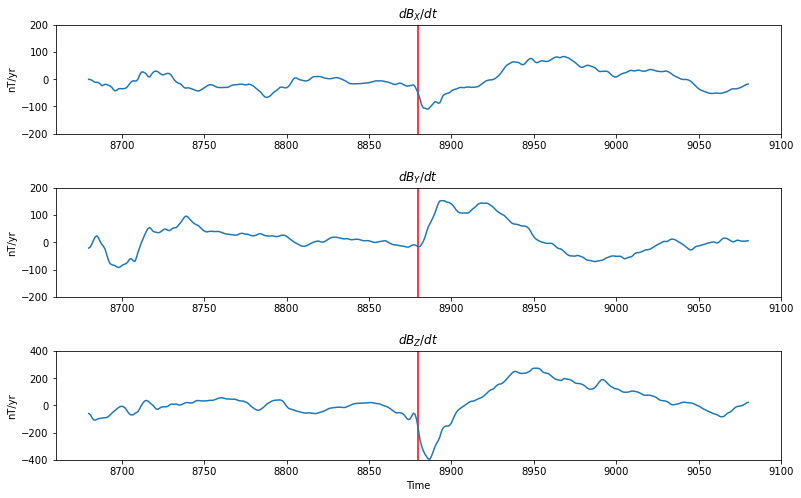

In [7]:
# plot SV series at theta = 90, phi = 45 which is close to the centre point of the jerk event in the SA.
radius = 6371.
theta = 90
phi = 45
jerk_number = 8 # in Python indexing (i.e. event 9)

# sample every year
time_yearly = np.arange(jerk_times[jerk_number]-200,jerk_times[jerk_number]+200+1)

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('nT/yr')
ax1.set_title(r'$d{B_X}/dt$')
a=200
ax2.vlines(jerk_times[jerk_number],-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax2.set_ylim(-200,200)
ax2.set_ylabel('nT/yr')
ax2.set_title(r'$d{B_Y}/dt$')
a=400
ax3.vlines(jerk_times[jerk_number],-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-400,400)
ax3.set_xlabel('Time')
ax3.set_ylabel('nT/yr')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
plt.savefig('Jerk9_SV_timeseries.pdf')

#### Run jerk finder on using a 10% relative error on 400 year interval (400 data).

In [8]:
run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )


CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    K_MIN = 0
    K_MAX = 100
    sigmas = np.array([10,5,10],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    THIN = 100
    NBINS = 100
    credible = 95
    RUNNING_MODE = 1
    burn_in = 10000
    NSAMPLE = 2000000+burn_in
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
     median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
     MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    print(i, Acceptance_rates)
    

0 [49.48329926 43.28041458  3.98189807  3.99296021]
1 [56.69810104 39.44734192  4.50033855  4.51344156]
2 [77.49980164 52.12829971  6.17755747  6.19471931]


#### Display the average absolute gradient for the 3 components:

<Figure size 432x288 with 0 Axes>

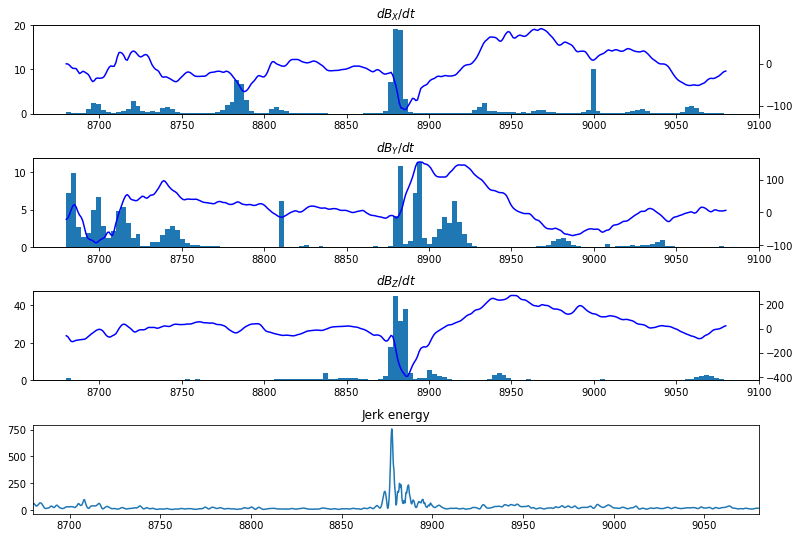

In [9]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, av_delta_hist_save[0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, av_delta_hist_save[1,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, av_delta_hist_save[2,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))



ax1b = ax1.twinx()
ax1b.plot(TIMES,Bx_dot,'b')
ax2b = ax2.twinx()
ax2b.plot(TIMES,By_dot,'b')
ax3b = ax3.twinx()
ax3b.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


#### Display the median absolute gradient for the 3 components:

<Figure size 432x288 with 0 Axes>

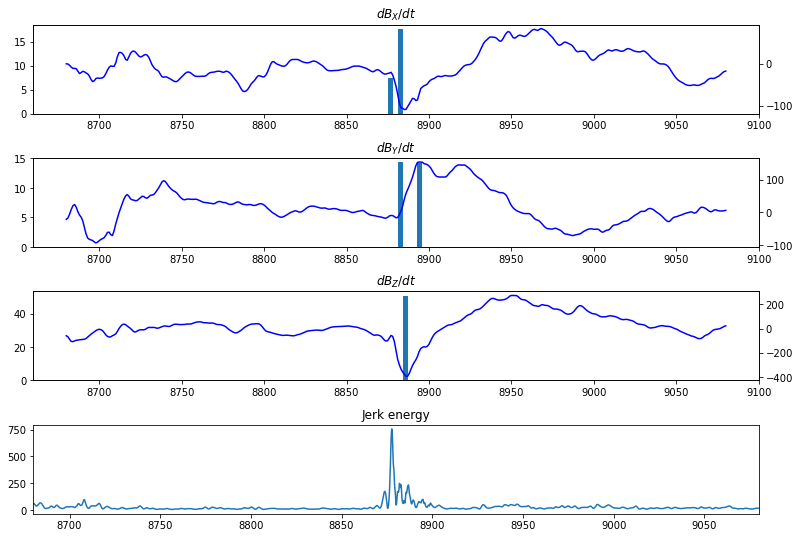

In [10]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, median_delta_hist_save[0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, median_delta_hist_save[1,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, median_delta_hist_save[2,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))



ax1b = ax1.twinx()
ax1b.plot(TIMES,Bx_dot,'b')
ax2b = ax2.twinx()
ax2b.plot(TIMES,By_dot,'b')
ax3b = ax3.twinx()
ax3b.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


#### Display the median with 95% credible bounds for the absolute gradient for the 3 components:

<Figure size 432x288 with 0 Axes>

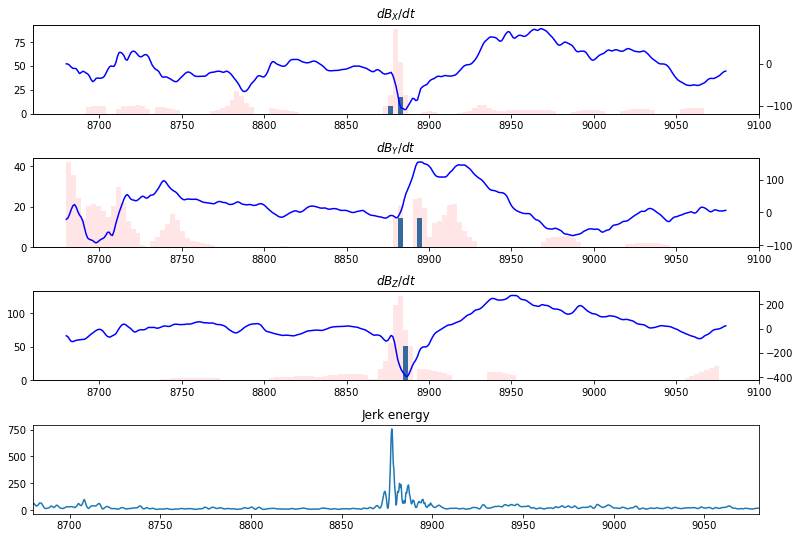

In [14]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, median_delta_hist_save[0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax1.bar(left_edges, upper_credible_delta_hist_save[0,:], color='red', alpha=0.1, align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax2.bar(left_edges, median_delta_hist_save[1,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, upper_credible_delta_hist_save[1,:], color='red', alpha=0.1, align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax3.bar(left_edges, median_delta_hist_save[2,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, upper_credible_delta_hist_save[2,:], color='red', alpha=0.1, align='edge', width = 1*(left_edges[1] - left_edges[0]))



ax1b = ax1.twinx()
ax1b.plot(TIMES,Bx_dot,'b')
ax2b = ax2.twinx()
ax2b.plot(TIMES,By_dot,'b')
ax3b = ax3.twinx()
ax3b.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


#### Stacked data:

Text(0.5, 1.0, 'Stacked data')

<Figure size 432x288 with 0 Axes>

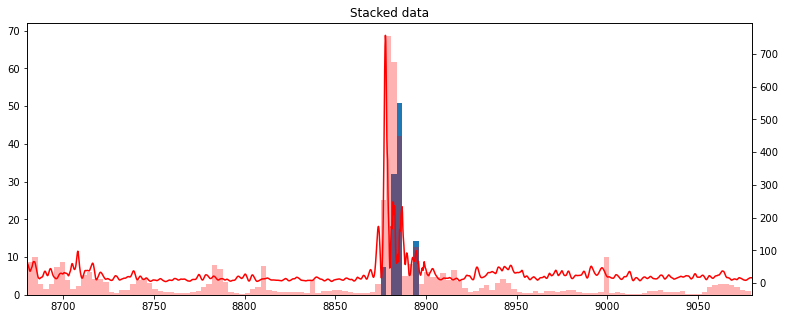

In [16]:
plt.figure()
f, (ax1) = plt.subplots(1, 1, figsize=(13,5) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, np.sum(median_delta_hist_save[:,:],axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax1.bar(left_edges, np.sum(av_delta_hist_save[:,:],axis=0), color='r', alpha=0.3, align='edge', width = 1*(left_edges[1] - left_edges[0]))


ax1b = ax1.twinx()

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax1b.plot(time_EJ, EJ,'r' )
ax1.set_xlim(time_yearly.min(), time_yearly.max() )

ax1.set_title(r'Stacked data')


#### Display the absolute gradient of the average for the 3 components:

In [25]:
# Define a function to calculate the change in slope. Uses one-sided differences excluding the query point.
# This avoids the case where an apex of the function modelled, is in between two grid points x_i, and x_{i+1}. 
# Here, the left one-sided gradient at x_i, and the right one-sided gradient at x_{i+1} will be accurate, 
# but using x_i and x_{i+1} to calculate the gradient will give a large error.

def calc_delta_slope(timeseries, delta_t):
    delta_slope = np.zeros( len(timeseries) )
    
    for i in range(len(timeseries)):
        if i > 2 and i < len(timeseries)-2 :
            delta_slope[i] = abs(timeseries[i+2] -  timeseries[i+1] - timeseries[i-1] + timeseries[i-2] )/delta_t
    return delta_slope

    

<Figure size 432x288 with 0 Axes>

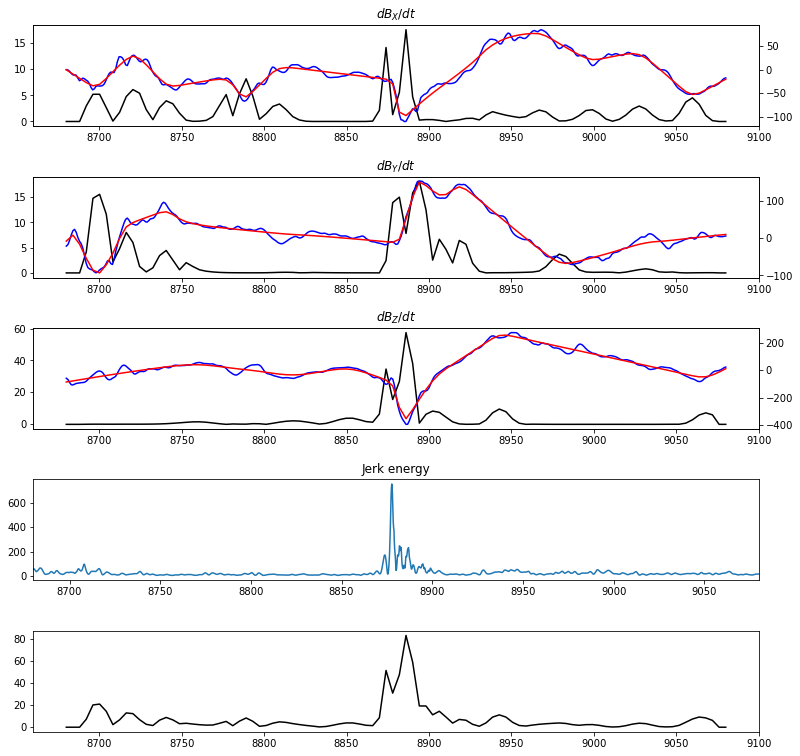

In [19]:
time_for_plotting = np.linspace(TIMES_MIN, TIMES_MAX,discretise_size,endpoint=True)

plt.figure()
f, (ax1, ax2,ax3,ax4, ax5) = plt.subplots(5, 1, figsize=(13,13) )
delta_t = time_for_plotting[1] - time_for_plotting[0]

ax1.plot( time_for_plotting, calc_delta_slope(av_hist_save[0,:],delta_t),'k')
ax1b = ax1.twinx()
ax1b.plot(TIMES,Bx_dot,'b')
ax1b.plot(time_for_plotting, av_hist_save[0,:],'r')


ax2.plot( time_for_plotting, calc_delta_slope(av_hist_save[1,:],delta_t),'k')
ax2b = ax2.twinx()
ax2b.plot(TIMES,By_dot,'b')
ax2b.plot(time_for_plotting, av_hist_save[1,:],'r')

ax3.plot( time_for_plotting, calc_delta_slope(av_hist_save[2,:],delta_t),'k')
ax3b = ax3.twinx()
ax3b.plot(TIMES,Bz_dot,'b')
ax3b.plot(time_for_plotting, av_hist_save[2,:],'r')


time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax5.plot( time_for_plotting, calc_delta_slope(av_hist_save[0,:],delta_t) + calc_delta_slope(av_hist_save[1,:],delta_t)+calc_delta_slope(av_hist_save[2,:],delta_t),'k')
ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


#### Comparison of stacked data

Jerk time from average gradient is 8879.500000
Jerk time from median gradient is 8885.500000
Jerk time from gradient of average is 8886.060606


<Figure size 432x288 with 0 Axes>

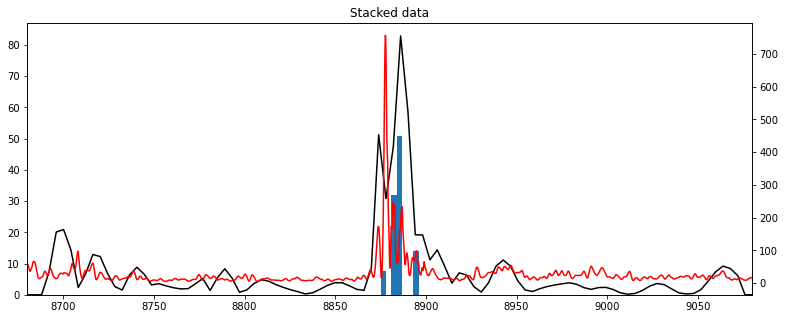

In [22]:
plt.figure()
f, (ax1) = plt.subplots(1, 1, figsize=(13,5) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, np.sum(median_delta_hist_save[:,:],axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))

delta_t = time_for_plotting[1] - time_for_plotting[0]
ax1.plot( time_for_plotting, calc_delta_slope(av_hist_save[0,:],delta_t) + calc_delta_slope(av_hist_save[1,:],delta_t)+calc_delta_slope(av_hist_save[2,:],delta_t),'k')
ax1b = ax1.twinx()

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax1b.plot(time_EJ, EJ,'r' )
ax1.set_xlim(time_yearly.min(), time_yearly.max() )

ax1.set_title(r'Stacked data')

time_index_delta = np.argmax(np.sum(av_delta_hist_save[:,:],axis=0))
print('Jerk time from average gradient is {0:f}'.format( (time_intervals_edges[time_index_delta] + time_intervals_edges[time_index_delta+1])/2.0))
time_index_delta = np.argmax(np.sum(median_delta_hist_save[:,:],axis=0))
print('Jerk time from median gradient is {0:f}'.format( (time_intervals_edges[time_index_delta] + time_intervals_edges[time_index_delta+1])/2.0))
print('Jerk time from gradient of average is {0:f}'.format(
time_for_plotting[(calc_delta_slope(
    av_hist_save[0,:],delta_t) + calc_delta_slope(av_hist_save[1,:],delta_t)+calc_delta_slope(av_hist_save[2,:],delta_t)
                  ).argmax()]) )

<Figure size 432x288 with 0 Axes>

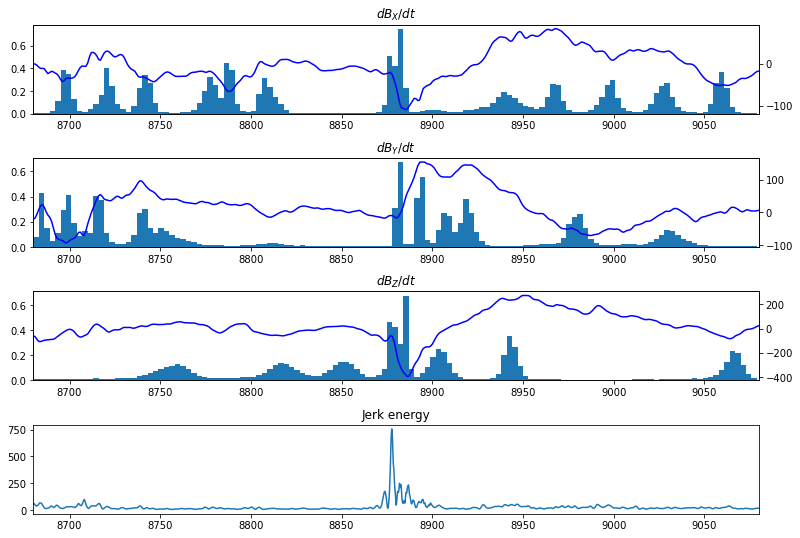

In [23]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:-1]
ax1.bar(left_edges, CP_hist_save[0,:]/fac, align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, CP_hist_save[1,:]/fac, align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, CP_hist_save[2,:]/fac, align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax5 = ax1.twinx()
ax5.plot(TIMES,Bx_dot,'b')
ax5 = ax2.twinx()
ax5.plot(TIMES,By_dot,'b')
ax5 = ax3.twinx()
ax5.plot(TIMES,Bz_dot,'b')
ax1.set_xlim(time_yearly.min(), time_yearly.max() )
ax2.set_xlim(time_yearly.min(), time_yearly.max() )
ax3.set_xlim(time_yearly.min(), time_yearly.max() )

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'zoomed.pdf')


#### Stacked probability:

(8680.0, 9080.0)

<Figure size 432x288 with 0 Axes>

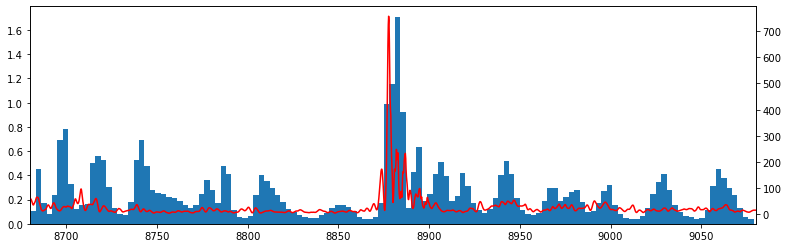

In [24]:
plt.figure()
f, (ax1 ) = plt.subplots(1, 1, figsize=(13,4) )
fac = (NSAMPLE-burn_in)/THIN
left_edges = time_intervals_edges[:-1]
ax1.bar(left_edges, np.sum(CP_hist_save[:,:],axis=0)/fac, align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax1b = ax1.twinx()
time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax1b.plot(time_EJ, EJ,'r' )
ax1.set_xlim(time_yearly.min(), time_yearly.max() )


#### Jerk time from delta slope or change point probability:

In [81]:
time_index_delta = np.argmax(np.sum(delta_hist_save[:,:],axis=0))
time_index_CP = np.argmax(np.sum(CP_hist_save[:,:],axis=0))

In [83]:
print('Jerk time from delta slope is {0:f}'.
      format( (time_intervals_edges[time_index_delta] + time_intervals_edges[time_index_delta+1])/2.0))
print('Jerk time from change point probability is {0:f}'.
      format( (time_intervals_edges[time_index_CP] + time_intervals_edges[time_index_CP+1])/2.0))

Jerk time from delta slope is 8879.500000
Jerk time from change point probability is 8882.500000


#### Try a different location

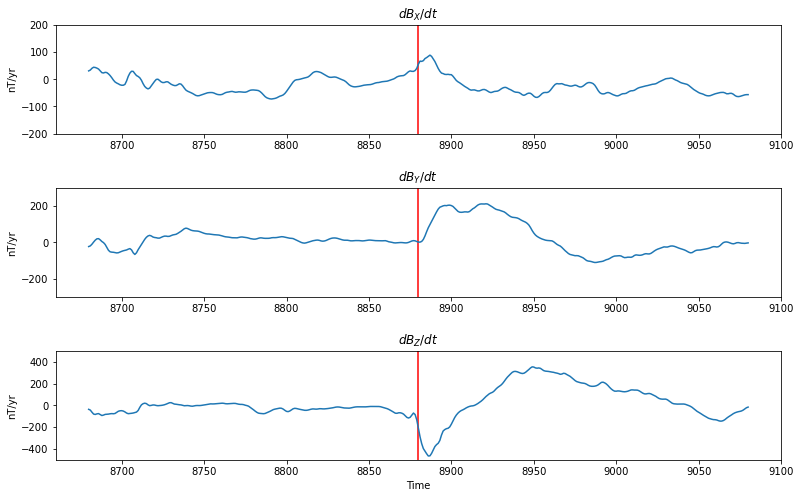

In [16]:
theta = 75
phi = 45

Br, Btheta, Bphi = cp.model_utils.synth_values(coeffs, radius, theta, phi,nmax=13)
Br_yearly,Btheta_yearly, Bphi_yearly = np.interp(time_yearly, time, Br ), np.interp(time_yearly, time, Btheta ), np.interp(time_yearly, time, Bphi )
Bx_dot, By_dot, Bz_dot = -np.gradient(Btheta_yearly,time_yearly), np.gradient(Bphi_yearly,time_yearly), -np.gradient(Br_yearly,time_yearly)


a = 200
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, figsize=(13,8) )
ax1.vlines(jerk_times[jerk_number],-a,a,'r')
ax1.plot( time_yearly,Bx_dot )
ax1.set_ylim(-a,a)
ax1.set_ylabel('nT/yr')
ax1.set_title(r'$d{B_X}/dt$')
a=300
ax2.vlines(jerk_times[jerk_number],-a,a,'r')
ax2.plot( time_yearly,By_dot )
#ax2.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax2.set_ylim(-300,300)
ax2.set_ylabel('nT/yr')
ax2.set_title(r'$d{B_Y}/dt$')
a=500
ax3.vlines(jerk_times[jerk_number],-a,a,'r')
ax3.plot( time_yearly,Bz_dot )
#ax3.set_xlim(lower_time_bounds[jerk_number],upper_time_bounds[jerk_number])
ax3.set_ylim(-500,500)
ax3.set_xlabel('Time')
ax3.set_ylabel('nT/yr')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)


In [17]:
run_components=[0,1,2] #compute for X,Y,Z components of SV
SV_error = 10

discretise_size = 100
TIMES = time_yearly
NUM_DATA = len(TIMES)
TIMES_MIN = TIMES.min()
TIMES_MAX = TIMES.max()
    
# ****************************************
# Define diagnostic time bins here
# ****************************************
time_intervals_edges = np.arange(TIMES_MIN,TIMES_MAX+1,3) #return bin spacing of 3 years, up to and including the end point if appropriate.
time_intervals_nbins = time_intervals_edges.shape[0]-1
av_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
median_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
lower_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )
upper_credible_delta_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=float )


CP_hist_save = np.zeros( (len(run_components),time_intervals_nbins), dtype=int )
av_hist_save =  np.zeros( (len(run_components),discretise_size), dtype=float )

for i in run_components:
    if i == 0:
        SV = Bx_dot
    elif i == 1:
        SV = By_dot
    else:
        SV = Bz_dot
        
    delta_SV = SV_error * 0.01 * (SV.max() - SV.min()) * np.ones(NUM_DATA,dtype=float)
    SV_MIN = -400
    SV_MAX = 400
    
    K_MIN = 0
    K_MAX = 100
    sigmas = np.array([10,5,10],dtype = float)
    TIME_grid = np.linspace(TIMES_MIN, TIMES_MAX, discretise_size, endpoint=True)
    # sigma_change_value = sigmas(1)
    # sigma_move = sigmas(2)
    # sigma_birth = sigmas(3)

    THIN = 100
    NBINS = 100
    credible = 95
    RUNNING_MODE = 1
    burn_in = 10000
    NSAMPLE = 2000000+burn_in
    Acceptance_rates=np.zeros(4)
    AV = np.zeros(discretise_size,dtype=float)
    SUP = np.zeros(discretise_size,dtype=float)
    INF = np.zeros(discretise_size,dtype=float)
    MEDIAN = np.zeros(discretise_size,dtype=float)
    MODE = np.zeros(discretise_size,dtype=float)
    MARGINAL_DENSITY = np.zeros( (discretise_size,NBINS),dtype=float )
    N_CP_hist = np.zeros( K_MAX, dtype=int)
    av_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    median_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    upper_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )
    lower_credible_delta_slope = np.zeros( time_intervals_nbins,dtype=float )

    CP = np.zeros( time_intervals_nbins, dtype=int )

    (Acceptance_rates, SUP, INF, AV, MEDIAN, MODE, CP, av_delta_slope, 
     median_delta_slope, upper_credible_delta_slope, lower_credible_delta_slope, 
     MARGINAL_DENSITY, N_CP_hist) = jerks.rjmcmc(
     sigmas=sigmas, burn_in=burn_in, 
     nsample=NSAMPLE, num_data=NUM_DATA, times=TIMES, y=SV, delta_y=delta_SV, 
     y_min=SV_MIN, y_max=SV_MAX, times_min=TIMES_MIN, times_max=TIMES_MAX, k_min=K_MIN, 
     k_max=K_MAX, discretise_size=discretise_size, time_intervals_nbins = time_intervals_nbins,time_intervals_edges = time_intervals_edges,
     thin=THIN, nbins=NBINS, credible=credible, running_mode=RUNNING_MODE)
    
    CP_hist_save[i,:] = CP[:]
    av_delta_hist_save[i,:] = av_delta_slope[:]
    median_delta_hist_save[i,:] = median_delta_slope[:]
    upper_credible_delta_hist_save[i,:] = upper_credible_delta_slope[:]
    lower_credible_delta_hist_save[i,:] = lower_credible_delta_slope[:]

    av_hist_save[i,:] = AV[:]
    print(i, Acceptance_rates)
    

0 [46.99100113 38.80169296  4.0139451   4.02479553]
1 [58.5951004  40.96406174  4.42636108  4.43865776]
2 [78.08679962 50.95556641  6.51719427  6.53529978]


In [ ]:
#### Plot the average models:

<Figure size 432x288 with 0 Axes>

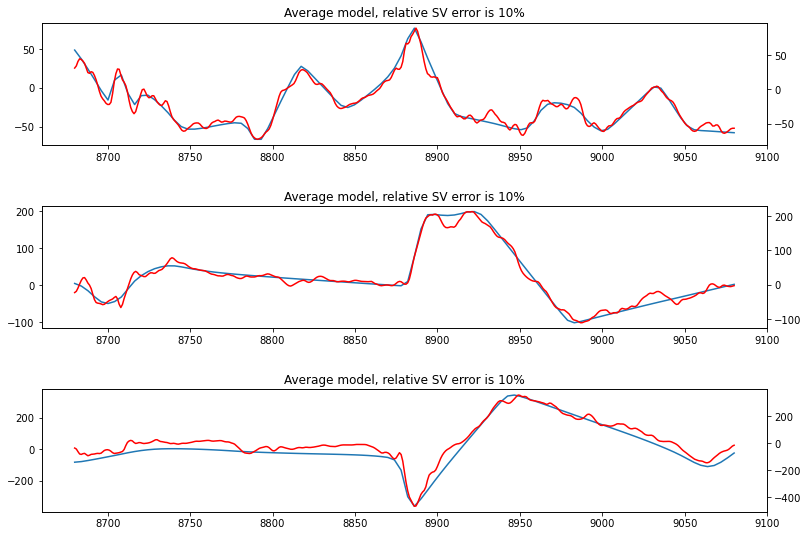

In [38]:
plt.figure()
time_for_plotting = np.linspace(TIMES_MIN, TIMES_MAX,discretise_size,endpoint=True)

f, ax = plt.subplots(av_hist_save.shape[0], 1, figsize=(13,9) )

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)

for i in range(ax.shape[0]):
    ax[i].set_title(r'Average model, relative SV error is 10%')
    ax[i].plot(time_for_plotting, av_hist_save[i,:])
    axb = ax[i].twinx()
    if i == 0:
        axb.plot(time_yearly, Bx_dot,'r' )
    if i == 1:
        axb.plot(time_yearly, By_dot,'r' )
    if i == 2:
        axb.plot(time_yearly, Bz_dot,'r' )

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)




#### Plot the average absolute gradient:

Text(0.5, 1.0, 'Stacked data')

<Figure size 432x288 with 0 Axes>

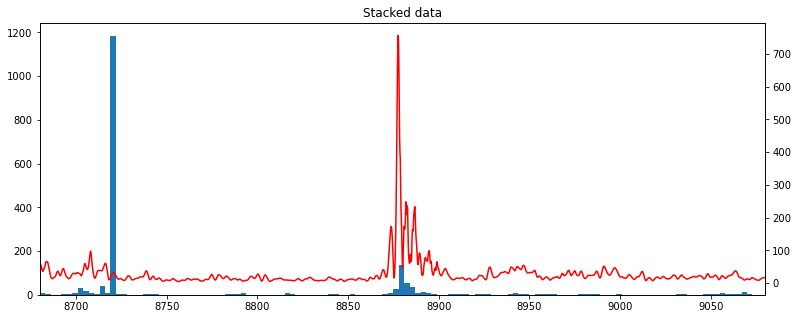

In [19]:
plt.figure()
f, (ax1) = plt.subplots(1, 1, figsize=(13,5) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, np.sum(av_delta_hist_save[:,:],axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax1b = ax1.twinx()

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax1b.plot(time_EJ, EJ,'r' )
ax1.set_xlim(time_yearly.min(), time_yearly.max() )

ax1.set_title(r'Stacked data')


#### Plot the x-component: there is a spurious feature at 8720.

Text(0.5, 1.0, 'Stacked data')

<Figure size 432x288 with 0 Axes>

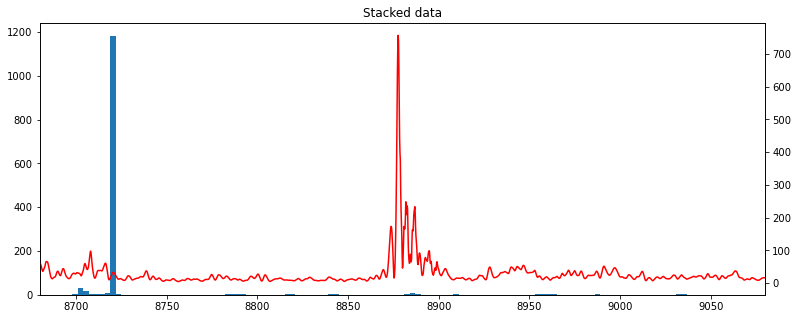

In [20]:
plt.figure()
f, (ax1) = plt.subplots(1, 1, figsize=(13,5) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, av_delta_hist_save[0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax1b = ax1.twinx()

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax1b.plot(time_EJ, EJ,'r' )
ax1.set_xlim(time_yearly.min(), time_yearly.max() )

ax1.set_title(r'Stacked data')


#### Display the median absolute gradient for the 3 components:

<Figure size 432x288 with 0 Axes>

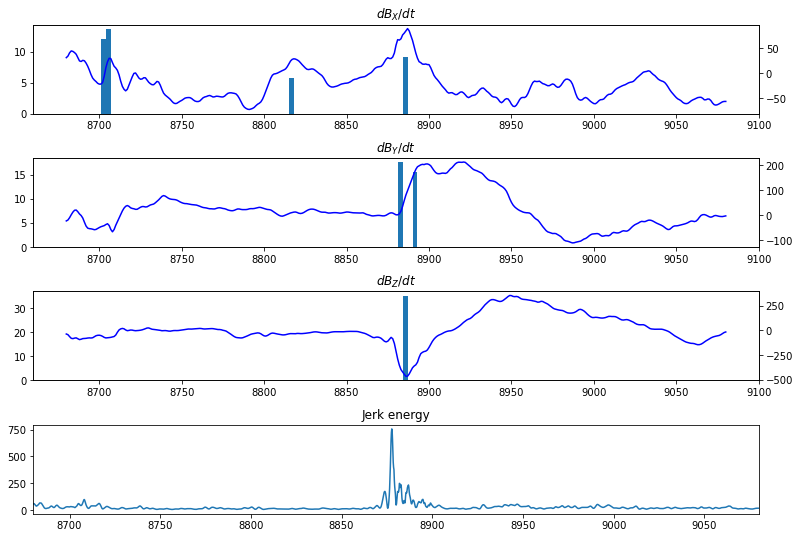

In [21]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, median_delta_hist_save[0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, median_delta_hist_save[1,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, median_delta_hist_save[2,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))



ax1b = ax1.twinx()
ax1b.plot(TIMES,Bx_dot,'b')
ax2b = ax2.twinx()
ax2b.plot(TIMES,By_dot,'b')
ax3b = ax3.twinx()
ax3b.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


#### Display the median with 95% credible bounds for the absolute gradient for the 3 components:

<Figure size 432x288 with 0 Axes>

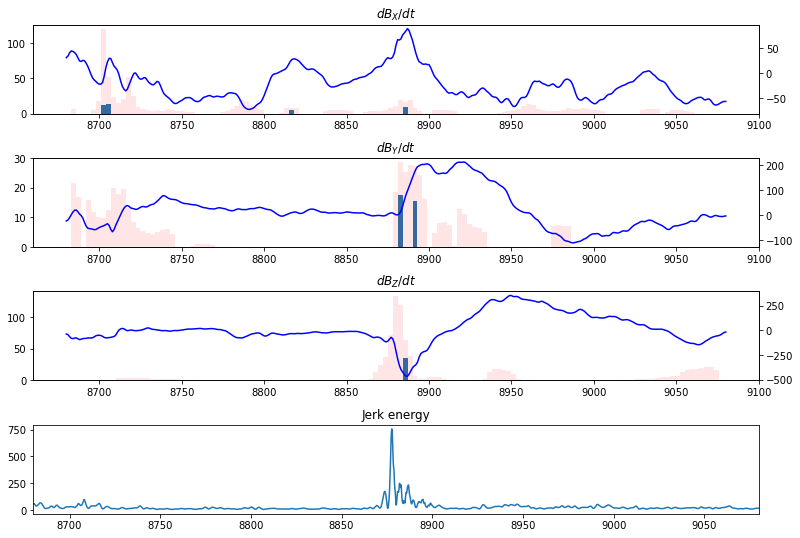

In [22]:
plt.figure()
f, (ax1, ax2,ax3,ax4) = plt.subplots(4, 1, figsize=(13,9) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, median_delta_hist_save[0,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax1.bar(left_edges, upper_credible_delta_hist_save[0,:], color='red', alpha=0.1, align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax2.bar(left_edges, median_delta_hist_save[1,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax2.bar(left_edges, upper_credible_delta_hist_save[1,:], color='red', alpha=0.1, align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax3.bar(left_edges, median_delta_hist_save[2,:], align='edge', width = 1*(left_edges[1] - left_edges[0]))
ax3.bar(left_edges, upper_credible_delta_hist_save[2,:], color='red', alpha=0.1, align='edge', width = 1*(left_edges[1] - left_edges[0]))



ax1b = ax1.twinx()
ax1b.plot(TIMES,Bx_dot,'b')
ax2b = ax2.twinx()
ax2b.plot(TIMES,By_dot,'b')
ax3b = ax3.twinx()
ax3b.plot(TIMES,Bz_dot,'b')

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


#### Plot the absolute gradient of the average: this is much better behaved.

<Figure size 432x288 with 0 Axes>

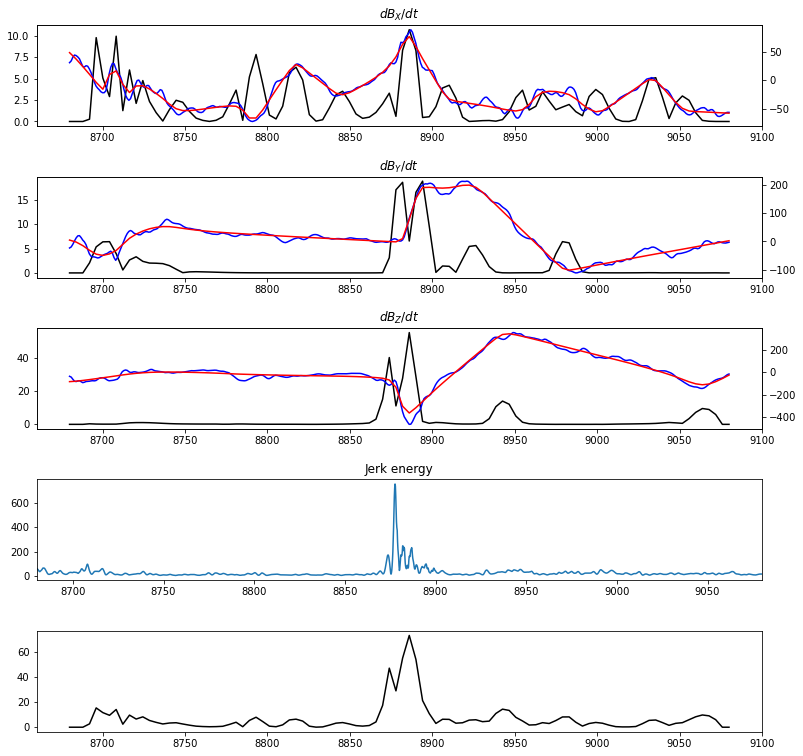

In [26]:
time_for_plotting = np.linspace(TIMES_MIN, TIMES_MAX,discretise_size,endpoint=True)

plt.figure()
f, (ax1, ax2,ax3,ax4, ax5) = plt.subplots(5, 1, figsize=(13,13) )
delta_t = time_for_plotting[1] - time_for_plotting[0]

ax1.plot( time_for_plotting, calc_delta_slope(av_hist_save[0,:],delta_t),'k')
ax1b = ax1.twinx()
ax1b.plot(TIMES,Bx_dot,'b')
ax1b.plot(time_for_plotting, av_hist_save[0,:],'r')


ax2.plot( time_for_plotting, calc_delta_slope(av_hist_save[1,:],delta_t),'k')
ax2b = ax2.twinx()
ax2b.plot(TIMES,By_dot,'b')
ax2b.plot(time_for_plotting, av_hist_save[1,:],'r')

ax3.plot( time_for_plotting, calc_delta_slope(av_hist_save[2,:],delta_t),'k')
ax3b = ax3.twinx()
ax3b.plot(TIMES,Bz_dot,'b')
ax3b.plot(time_for_plotting, av_hist_save[2,:],'r')


time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax4.plot(time_EJ, EJ )
ax4.set_xlim(time_yearly.min(), time_yearly.max() )
ax4.set_title('Jerk energy')

ax5.plot( time_for_plotting, calc_delta_slope(av_hist_save[0,:],delta_t) + calc_delta_slope(av_hist_save[1,:],delta_t)+calc_delta_slope(av_hist_save[2,:],delta_t),'k')
ax1.set_title(r'$d{B_X}/dt$')
ax2.set_title(r'$d{B_Y}/dt$')
ax3.set_title(r'$d{B_Z}/dt$')
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
#plt.savefig('Jerk9_xyz_like_'+str(SV_error)+'.pdf')


#### Comparison of stacked data:

Jerk time from median gradient is 8885.500000
Jerk time from average gradient is 8720.500000
Jerk time from gradient of average is 8886.060606


<Figure size 432x288 with 0 Axes>

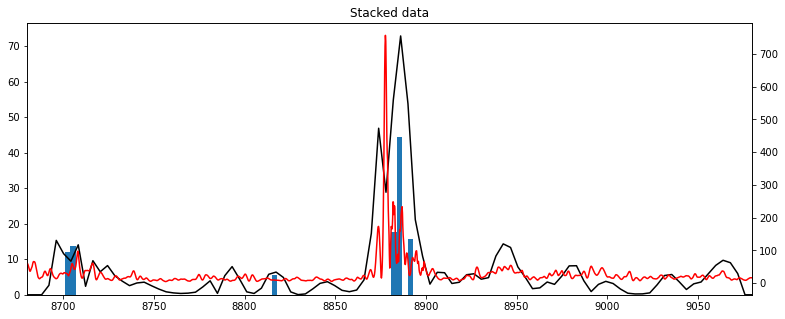

In [29]:
plt.figure()
f, (ax1) = plt.subplots(1, 1, figsize=(13,5) )
left_edges = time_intervals_edges[:-1]
fac = (NSAMPLE-burn_in)/THIN
ax1.bar(left_edges, np.sum(median_delta_hist_save[:,:],axis=0), align='edge', width = 1*(left_edges[1] - left_edges[0]))

ax1.plot( time_for_plotting, calc_delta_slope(av_hist_save[0,:],delta_t) + calc_delta_slope(av_hist_save[1,:],delta_t)+calc_delta_slope(av_hist_save[2,:],delta_t),'k')
ax1b = ax1.twinx()

time_EJ, EJ = np.loadtxt('Jerk_energy.dat',unpack=True)
ax1b.plot(time_EJ, EJ,'r' )
ax1.set_xlim(time_yearly.min(), time_yearly.max() )

ax1.set_title(r'Stacked data')

time_index_delta = np.argmax(np.sum(median_delta_hist_save[:,:],axis=0))
print('Jerk time from median gradient is {0:f}'.format( (time_intervals_edges[time_index_delta] + time_intervals_edges[time_index_delta+1])/2.0))

time_index_delta = np.argmax(np.sum(av_delta_hist_save[:,:],axis=0))
print('Jerk time from average gradient is {0:f}'.format( (time_intervals_edges[time_index_delta] + time_intervals_edges[time_index_delta+1])/2.0))

print('Jerk time from gradient of average is {0:f}'.format(
time_for_plotting[(calc_delta_slope(
    av_hist_save[0,:],delta_t) + calc_delta_slope(av_hist_save[1,:],delta_t)+calc_delta_slope(av_hist_save[2,:],delta_t)
                  ).argmax()]) )